# ChatGLM2-6b微调教程

干货预警：这可能是你能够找到的最容易懂的，最完整的，适用于各种NLP任务的开源LLM的finetune教程~

ChatGLM2-6b是清华开源的小尺寸LLM，只需要一块普通的显卡(32G较稳妥)即可推理和微调，是目前社区非常活跃的一个开源LLM。

本范例使用非常简单的，外卖评论数据集来实施微调，让ChatGLM2-6b来对一段外卖评论区分是好评还是差评。

可以发现，经过微调后的模型，相比直接 3-shot-prompt 可以取得明显更好的效果。

值得注意的是，尽管我们以文本分类任务为例，实际上，任何NLP任务，例如，命名实体识别，翻译，聊天对话等等，都可以通过加上合适的上下文，转换成一个对话问题，并针对我们的使用场景，设计出合适的数据集来微调ChatGLM2.



In [ ]:
#安装环境

#chatglm
!pip install protobuf>=3.19.5,<3.20.1
!pip install icetk
!pip install cpm_kernels==1.0.11
!pip install transformers


#finetune
!pip install -U accelerate
!pip install datasets
!pip install -U peft 
!pip install -U torchkeras 


公众号算法美食屋后台回复关键词： torchkeras，获取本文notebook源代码，以及waimai数据集下载链接~


## 〇，预训练模型

我们需要从 https://huggingface.co/THUDM/chatglm2-6b 下载chatglm2的模型。

国内可能速度会比较慢，总共有14多个G，网速不太好的话，大概可能需要一两个小时。

如果网络不稳定，也可以手动从这个页面一个一个下载全部文件然后放置到 一个文件夹中例如 'chatglm2-6b' 以便读取。



In [1]:
from transformers import  AutoModel,AutoTokenizer
model_name = "chatglm2-6b" #或者远程 “THUDM/chatglm2-6b”
tokenizer = AutoTokenizer.from_pretrained(
    model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name,trust_remote_code=True).half().cuda()


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [2]:
prompt = """文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。

下面是一些范例:

味道真不错 -> 好评
太辣了，吃不下都  -> 差评

请对下述评论进行分类。返回'好评'或者'差评'，无需其它说明和解释。

xxxxxx ->

"""

def get_prompt(text):
    return prompt.replace('xxxxxx',text)


In [3]:
response, his = model.chat(tokenizer, get_prompt('味道不错，下次还来'), history=[])
print(response)  

好评


In [4]:
#增加4个范例
his.append(("太贵了 -> ","差评"))
his.append(("非常快，味道好 -> ","好评"))

his.append(("这么咸真的是醉了 -> ","差评"))
his.append(("价格感人 优惠多多 -> ","好评"))

我们来测试一下

In [5]:
response, history = model.chat(tokenizer, "一言难尽啊 -> ", history=his)
print(response) 

response, history = model.chat(tokenizer, "还凑合一般般 -> ", history=his)
print(response) 

response, history = model.chat(tokenizer, "我家狗狗爱吃的 -> ", history=his)
print(response) 


差评
差评
好评


In [6]:
#封装成一个函数吧~
def predict(text):
    response, history = model.chat(tokenizer, f"{text} ->", history=his,
    temperature=0.01)
    return response 

predict('死鬼，咋弄得这么有滋味呢') #在我们精心设计的一个评论下，ChatGLM2-6b终于预测错误了~

'差评'

我们拿外卖数据集测试一下未经微调，纯粹的 6-shot prompt 的准确率。

In [7]:
import pandas as pd 
import numpy as np 
import datasets 


df = pd.read_csv("data/waimai_10k.csv")

df['tag'] = df['label'].map({0:'差评',1:'好评'})
df = df.rename({'review':'text'},axis = 1)

dfgood = df.query('tag=="好评"')
dfbad = df.query('tag=="差评"').head(len(dfgood)) #采样部分差评，让好评差评平衡
df = pd.concat([dfgood,dfbad])


print(df['tag'].value_counts())


好评    4000
差评    4000
Name: tag, dtype: int64


In [8]:
ds_dic = datasets.Dataset.from_pandas(df).train_test_split(
    test_size = 2000,shuffle=True, seed = 43)
dftrain = ds_dic['train'].to_pandas()
dftest = ds_dic['test'].to_pandas()
dftrain.to_parquet('data/dftrain.parquet')
dftest.to_parquet('data/dftest.parquet')


In [40]:
preds = ['' for x in dftest['tag']] 

In [41]:
from tqdm import tqdm 
for i in tqdm(range(len(dftest))):
    text = dftest['text'].loc[i]
    preds[i] = predict(text)

100%|██████████| 2000/2000 [03:08<00:00, 10.61it/s]


In [43]:
dftest['pred'] = preds 

In [44]:
dftest.pivot_table(index='tag',columns = 'pred',values='text',aggfunc='count')

pred,好评,差评,"无法确定评论的具体内容,因为只看到了一次评论。无法进行分类。",负面
tag,,,,
好评,809.0,185.0,NaN,NaN
差评,57.0,947.0,1.0,1.0


In [45]:
acc = len(dftest.query('tag==pred'))/len(dftest)

In [46]:
print('acc=',acc)

acc= 0.878


可以看到，微调之前，我们的模型准确率为87.8%，下面我们通过6000条左右数据的微调，看看能否把acc打上去~ 😋 

## 一，准备数据

我们需要把数据整理成对话的形式，即 context 和 target 的配对，然后拼到一起作为一条样本。

ChatGLM模型本质上做的是一个文字接龙的游戏，即给定一段话的上半部分，它会去续写下半部分。

我们这里指定上半部分为我们设计的文本分类任务的prompt，下半部分为文本分类结果。

所以我们微调的目标就是让它预测的下半部分跟我们的设定的文本分类一致。



### 1，数据加载

In [9]:
import pandas as pd 
import numpy as np  
import datasets 

dftrain = pd.read_parquet('data/dftrain.parquet')
dftest = pd.read_parquet('data/dftest.parquet')


In [10]:
dftrain['tag'].value_counts() 

好评    3006
差评    2994
Name: tag, dtype: int64

In [11]:
#将上下文整理成与推理时候一致，参照model.chat中的源码~
#model.build_inputs??
def build_inputs(query, history):
    prompt = ""
    for i, (old_query, response) in enumerate(history):
        prompt += "[Round {}]\n\n问：{}\n\n答：{}\n\n".format(i + 1, old_query, response)
    prompt += "[Round {}]\n\n问：{} -> \n\n答：".format(len(history) + 1, query)
    return prompt 

In [12]:
print(build_inputs('味道不太行',history=his))


[Round 1]

问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。

下面是一些范例:

味道真不错 -> 好评
太辣了，吃不下都  -> 差评

请对下述评论进行分类。返回'好评'或者'差评'，无需其它说明和解释。

味道不错，下次还来 ->



答：好评

[Round 2]

问：太贵了 -> 

答：差评

[Round 3]

问：非常快，味道好 -> 

答：好评

[Round 4]

问：这么咸真的是醉了 -> 

答：差评

[Round 5]

问：价格感人 优惠多多 -> 

答：好评

[Round 6]

问：味道不太行 -> 

答：


In [13]:
dftrain['context'] = [build_inputs(x,history=his) for x in dftrain['text']]
dftrain['target'] = [x for x in dftrain['tag']]
dftrain = dftrain[['context','target']]

dftest['context'] = [build_inputs(x,history=his) for x in dftest['text']]
dftest['target'] = [x for x in dftest['tag']]
dftest = dftest[['context','target']]

dftest 

,context,target
0,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,差评
1,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,好评
2,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,差评
3,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,好评
4,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,差评
...,...,...
1995,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,差评
1996,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,差评
1997,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,好评
1998,[Round 1]\n\n问：文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者...,好评


In [14]:
ds_train = datasets.Dataset.from_pandas(dftrain)
ds_val = datasets.Dataset.from_pandas(dftest)


### 2，token编码

为了将文本数据喂入模型，需要将词转换为token。

也就是把context转化成context_ids，把target转化成target_ids. 

同时，我们还需要将context_ids和target_ids拼接到一起作为模型的input_ids。

这是为什么呢？

因为ChatGLM2基座模型是一个TransformerDecoder结构，是一个被预选练过的纯粹的语言模型(LLM，Large Lauguage Model)。

一个纯粹的语言模型，本质上只能做一件事情，那就是计算任意一段话像'人话'的概率。

我们将context和target拼接到一起作为input_ids， ChatGLM2 就可以判断这段对话像'人类对话'的概率。

在训练的时候我们使用梯度下降的方法来让ChatGLM2的判断更加准确。

训练完成之后，在预测的时候，我们就可以利用贪心搜索或者束搜索的方法按照最像"人类对话"的方式进行更合理的文本生成。


In [15]:
from tqdm import tqdm
import transformers

model_name = "chatglm2-6b"
max_seq_length = 512
skip_over_length = True

tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name, trust_remote_code=True)

config = transformers.AutoConfig.from_pretrained(
    model_name, trust_remote_code=True, device_map='auto')

def preprocess(example):
    context = example["context"]
    target = example["target"]
    
    context_ids = tokenizer.encode(
            context, 
            max_length=max_seq_length,
            truncation=True)
    
    target_ids = tokenizer.encode(
        target,
        max_length=max_seq_length,
        truncation=True,
        add_special_tokens=False)
    
    input_ids = context_ids + target_ids + [config.eos_token_id]
    
    return {"input_ids": input_ids, "context_len": len(context_ids),'target_len':len(target_ids)}


In [16]:
ds_train_token = ds_train.map(preprocess).select_columns(['input_ids', 'context_len','target_len'])
if skip_over_length:
    ds_train_token = ds_train_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [17]:
ds_val_token = ds_val.map(preprocess).select_columns(['input_ids', 'context_len','target_len'])
if skip_over_length:
    ds_val_token = ds_val_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

### 3, 管道构建

In [18]:
def data_collator(features: list):
    len_ids = [len(feature["input_ids"]) for feature in features]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, feature in sorted(zip(len_ids, features), key=lambda x: -x[0]):
        ids = feature["input_ids"]
        context_len = feature["context_len"]
        
        labels = (
            [-100] * (context_len - 1) + ids[(context_len - 1) :] + [-100] * (longest - length)
        ) #-100标志位后面会在计算loss时会被忽略不贡献损失，我们集中优化target部分生成的loss
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labels))
        
        
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }


In [69]:
import torch 
dl_train = torch.utils.data.DataLoader(ds_train_token,num_workers=2,batch_size=4,
                                       pin_memory=True,shuffle=True,
                                       collate_fn = data_collator)
dl_val = torch.utils.data.DataLoader(ds_val_token,num_workers=2,batch_size=4,
                                    pin_memory=True,shuffle=True,
                                     collate_fn = data_collator)


In [70]:
for batch in dl_train:
    break 
    

In [72]:
dl_train.size = 300 #用约300个step做一次验证

## 二，定义模型

In [73]:
import warnings
warnings.filterwarnings("ignore")


In [74]:
from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoConfig
import torch
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

model = AutoModel.from_pretrained("chatglm2-6b",
                                  load_in_8bit=False, 
                                  trust_remote_code=True, 
                                  device_map='auto')

model.supports_gradient_checkpointing = True  #节约cuda
model.gradient_checkpointing_enable()
model.enable_input_require_grads()
#model.lm_head = CastOutputToFloat(model.lm_head)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
)

model = get_peft_model(model, peft_config)
model.is_parallelizable = True
model.model_parallel = True
model.print_trainable_parameters()


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

trainable params: 1949696 || all params: 6245533696 || trainable%: 0.031217444255383614


In [75]:
!nvidia-smi 

Sun Jul  2 22:20:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.54       Driver Version: 510.54       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:CA:00.0 Off |                    0 |
| N/A   52C    P0    71W / 300W |  43112MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 三，训练模型

我们使用我们的梦中情炉torchkeras来实现最优雅的训练循环~

注意这里，为了更加高效地保存和加载参数，我们覆盖了KerasModel中的load_ckpt和save_ckpt方法，

仅仅保存和加载lora权重，这样可以避免加载和保存全部模型权重造成的存储问题。

In [76]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint.pt', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint.pt'):
    self.net = self.net.from_pretrained(self.net,ckpt_path)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 


In [77]:
keras_model = KerasModel(model,loss_fn = None,
        optimizer=torch.optim.AdamW(model.parameters(),lr=2e-6))
ckpt_path = 'waimai_chatglm4'


<<<<<< ⚡️ cuda is used >>>>>>


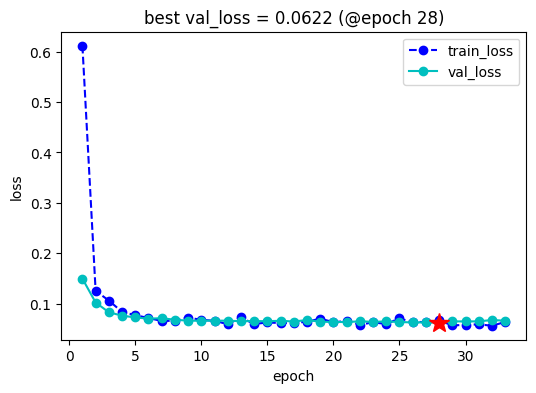

<<<<<< val_loss without improvement in 5 epoch,early stopping >>>>>>


,epoch,train_loss,lr,val_loss
0,1,0.611697,0.000002,0.149582
1,2,0.125421,0.000002,0.102242
2,3,0.106098,0.000002,0.082890
3,4,0.083643,0.000002,0.076146
4,5,0.077177,0.000002,0.072570
5,6,0.071423,0.000002,0.070248
6,7,0.065652,0.000002,0.071042
7,8,0.066049,0.000002,0.068135
8,9,0.072343,0.000002,0.066182
9,10,0.067834,0.000002,0.066134


In [78]:
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=100,patience=5,
                monitor='val_loss',mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16'
               )


## 四，验证模型

In [79]:
from peft import PeftModel 
model = AutoModel.from_pretrained("chatglm2-6b",
                                  load_in_8bit=False, 
                                  trust_remote_code=True, 
                                  device_map='auto')
model = PeftModel.from_pretrained(model,ckpt_path)
model = model.merge_and_unload() #合并lora权重


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [137]:

def predict(text):
    response, history = model.chat(tokenizer, f"{text} -> ", history=his,
    temperature=0.01)
    return response 

predict('死鬼，咋弄得这么有滋味呢') 


'差评'

In [129]:
dftest = pd.read_parquet('data/dftest.parquet')

In [130]:
preds = ['' for x in dftest['text']]

In [131]:
from tqdm import tqdm 
for i in tqdm(range(len(dftest))):
    text = dftest['text'].loc[i]
    preds[i] = predict(text)

100%|██████████| 2000/2000 [03:39<00:00,  9.11it/s]


In [132]:
dftest['pred'] = preds 

In [133]:
dftest.pivot_table(index='tag',columns = 'pred',values='text',aggfunc='count')

pred,好评,差评
tag,,
好评,888,106
差评,88,918


In [136]:
acc = len(dftest.query('tag==pred'))/len(dftest)
print('acc=',acc)

acc= 0.903


🤗还行，用6000条数据，训练了一个小时左右，准确率到了90.3%，比未经微调的prompt方案的87.8%相比涨了两个多点~

## 五，使用模型

我们可以调整温度temperature参数，看看有没有机会把这个评论：

'死鬼，咋弄得这么有滋味呢' 预测正确

In [143]:
def predict(text,temperature=0.8):
    response, history = model.chat(tokenizer, f"{text} -> ", history=his,
    temperature=temperature)
    return response 

for i in range(10):
    print(predict('死鬼，咋弄得这么有滋味呢')) 

差评
好评
好评
好评
差评
差评
好评
差评
差评
好评


可以看到，这个评论模型其实是不太吃得准它是好评还是差评的，毕竟，死鬼这个词的内涵太丰富了，跟字面的意思并不一样😋😋

In [147]:
#模型的其它能力基本没有受到影响
response, history = model.chat(tokenizer, "跑步比赛如果你超过了第二名，你会成为第几名？", history=[])
print(response)

如果在跑步比赛中超过了第二名,那么现在就是第二名。如果想要知道现在排名第几,需要知道自己和其他人的成绩。如果知道了所有人的成绩,就可以计算出自己在所有选手中的排名。


## 六，保存模型

可以将模型和tokenizer都保存到一个新的路径，便于直接加载。

In [153]:
model.save_pretrained("chatglm2-6b-waimai", max_shard_size='1GB')

In [154]:
tokenizer.save_pretrained("chatglm2-6b-waimai")

('chatglm2-6b-waimai/tokenizer_config.json',
 'chatglm2-6b-waimai/special_tokens_map.json',
 'chatglm2-6b-waimai/tokenizer.model',
 'chatglm2-6b-waimai/added_tokens.json')

还需要将相关的py文件也复制过去。

In [159]:
!ls chatglm2-6b  

MODEL_LICENSE.txt		  pytorch_model-00005-of-00007.bin
README.md			  pytorch_model-00006-of-00007.bin
config.json			  pytorch_model-00007-of-00007.bin
configuration_chatglm.py	  pytorch_model.bin.index.json
modeling_chatglm.py		  quantization.py
pytorch_model-00001-of-00007.bin  tokenization_chatglm.py
pytorch_model-00002-of-00007.bin  tokenizer.model
pytorch_model-00003-of-00007.bin  tokenizer_config.json
pytorch_model-00004-of-00007.bin


In [160]:
!cp  chatglm2-6b/*.py chatglm2-6b-waimai/

In [161]:
!ls chatglm2-6b-waimai 

config.json			  pytorch_model-00010-of-00015.bin
configuration_chatglm.py	  pytorch_model-00011-of-00015.bin
generation_config.json		  pytorch_model-00012-of-00015.bin
modeling_chatglm.py		  pytorch_model-00013-of-00015.bin
pytorch_model-00001-of-00015.bin  pytorch_model-00014-of-00015.bin
pytorch_model-00002-of-00015.bin  pytorch_model-00015-of-00015.bin
pytorch_model-00003-of-00015.bin  pytorch_model.bin.index.json
pytorch_model-00004-of-00015.bin  quantization.py
pytorch_model-00005-of-00015.bin  special_tokens_map.json
pytorch_model-00006-of-00015.bin  tokenization_chatglm.py
pytorch_model-00007-of-00015.bin  tokenizer.model
pytorch_model-00008-of-00015.bin  tokenizer_config.json
pytorch_model-00009-of-00015.bin


In [162]:
from transformers import  AutoModel,AutoTokenizer
model_name = "chatglm2-6b-waimai" 
tokenizer = AutoTokenizer.from_pretrained(
    model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name,
        trust_remote_code=True).half().cuda()

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [164]:
prompt = """文本分类任务：将一段用户给外卖服务的评论进行分类，分成好评或者差评。

下面是一些范例:

味道真不错 -> 好评
太辣了，吃不下都  -> 差评

请对下述评论进行分类。返回'好评'或者'差评'，无需其它说明和解释。

xxxxxx ->

"""

def get_prompt(text):
    return prompt.replace('xxxxxx',text)


In [166]:
response, his = model.chat(tokenizer, get_prompt('狗子，怎么做的这么好吃呀？'), history=[])
print(response)  

好评


感觉不错的话，记得点个star支持一下一个有毅力的吃货哦！